# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
import pickle as pkl
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

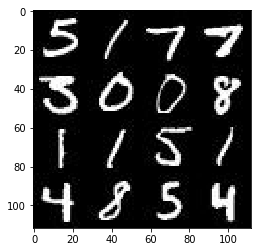

In [3]:
show_n_images = 24

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

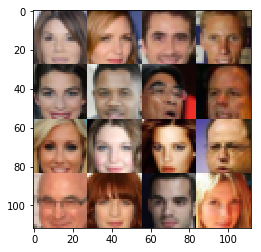

In [4]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_input = tf.placeholder(dtype=tf.float32,
                                shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(None), name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    # input is 28x28x1 for mnist
    # input is 28x28x3 for faces
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu_1 = tf.maximum(alpha * conv_1, conv_1)

        conv_2 = tf.layers.conv2d(lrelu_1, 128, 5, 2, 'SAME')
        batch_norm_2 = tf.layers.batch_normalization(conv_2, training=True)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        conv_3 = tf.layers.conv2d(lrelu_2, 256, 5, 1, 'SAME')
        batch_norm_3 = tf.layers.batch_normalization(conv_3, training=True)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
       
        flatten = tf.reshape(lrelu_3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        x_1 = tf.layers.dense(z, 2*2*512)
        
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        deconv_3 = tf.layers.conv2d_transpose(lrelu_2, 256, 5, 2, padding='VALID')
        batch_norm_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        deconv_4 = tf.layers.conv2d_transpose(lrelu_3, 128, 5, 2, padding='SAME')
        batch_norm_4 = tf.layers.batch_normalization(deconv_4, training=is_train)
        lrelu_4 = tf.maximum(alpha * batch_norm_4, batch_norm_4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu_4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param lr: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    print_every = 50
    show_every = 200

    out_channel_dim = len(data_image_mode)
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    real_input, z_input, lr_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                batch_images = batch_images * 2
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_tensor: lr})
                _ = sess.run(g_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_tensor: lr})
                
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess,
                                          n_images=16,
                                          input_z=z_input,
                                          out_channel_dim=out_channel_dim,
                                          image_mode=data_image_mode)
        
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.7328


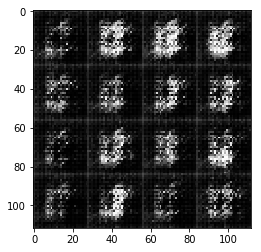

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 0.7341


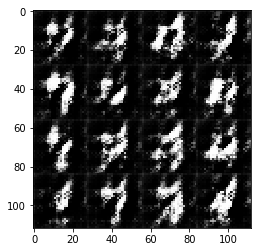

Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.7223


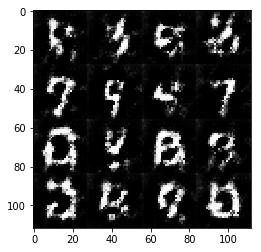

Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.8362
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 0.8057


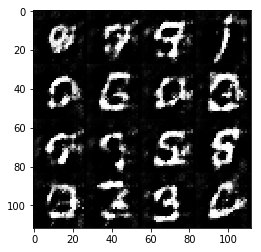

Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.7622


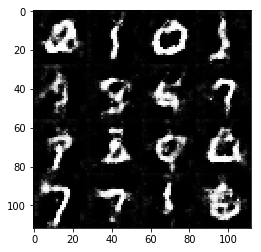

Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.8026


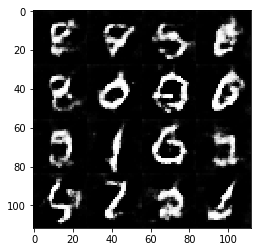

Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.7262
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.7709


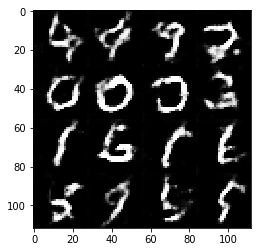

Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.7530


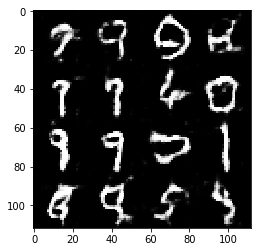

Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.7508


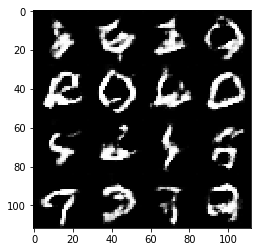

Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.8538


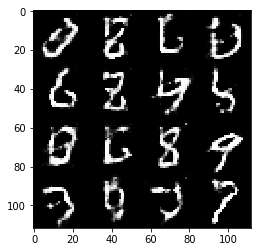

Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.0352


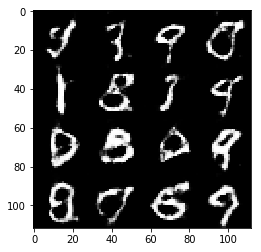

Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 0.8848


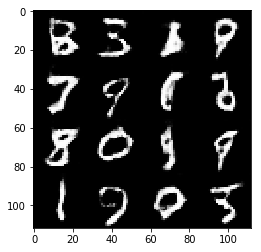

Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 0.8232
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 0.7115


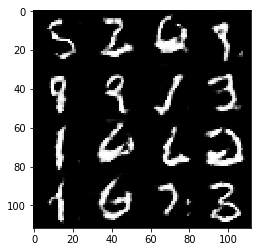

Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.7737


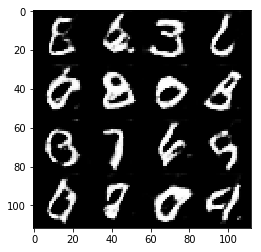

Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 0.9062


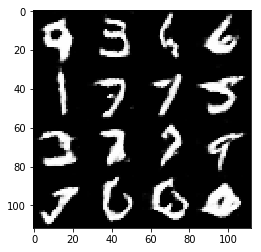

Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.5550
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 0.8424


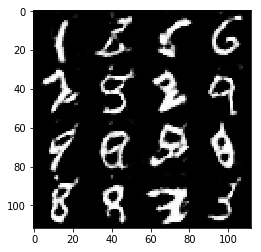

Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.2060
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 1.5066


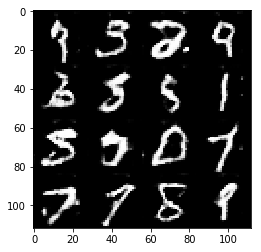

Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 1.2101
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.4593


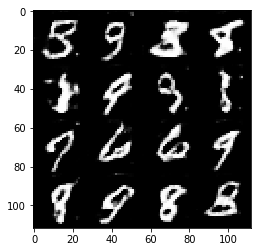

Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 1.2419
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.0733


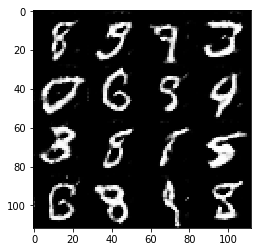

Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 1.6141


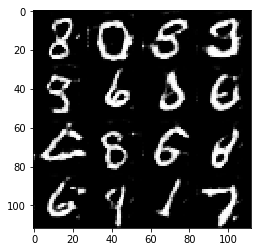

Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 1.1005


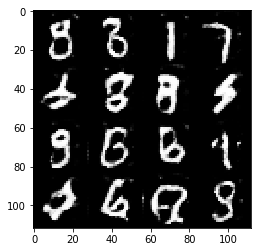

Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.8682... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 1.2937


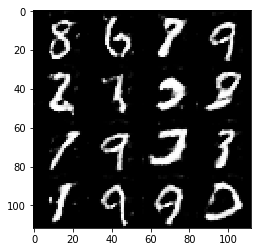

Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.7831


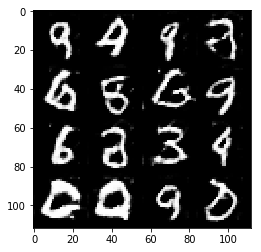

Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 0.4232... Generator Loss: 1.4771
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 1.3597
Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 1.9633


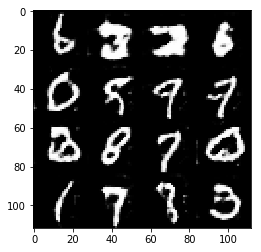

Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.4144
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 0.3552... Generator Loss: 1.6457
Epoch 2/2... Discriminator Loss: 0.4428... Generator Loss: 1.6986


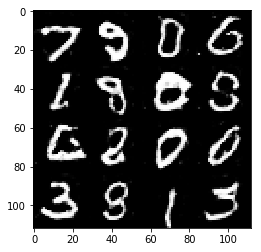

Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 0.4803... Generator Loss: 1.2978
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.4913
Epoch 2/2... Discriminator Loss: 0.3202... Generator Loss: 1.9439


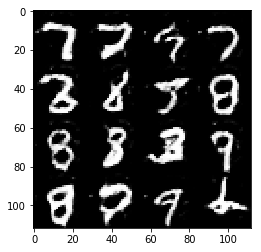

Epoch 2/2... Discriminator Loss: 0.5075... Generator Loss: 1.7408
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 1.6489


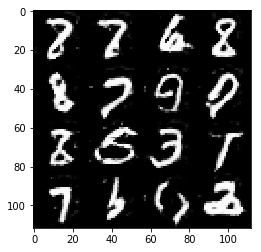

Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 0.3785... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 0.4352... Generator Loss: 1.4337
Epoch 2/2... Discriminator Loss: 0.2732... Generator Loss: 1.7989


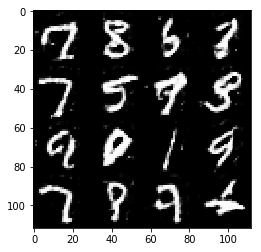

Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.4224
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.3639


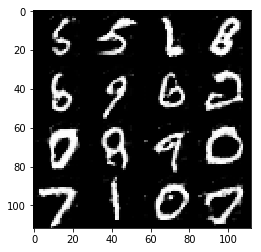

Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 0.3903... Generator Loss: 2.2168
Epoch 2/2... Discriminator Loss: 0.2749... Generator Loss: 2.4795
Epoch 2/2... Discriminator Loss: 0.2992... Generator Loss: 1.9219


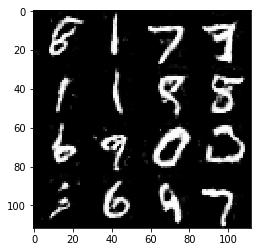

Epoch 2/2... Discriminator Loss: 0.4267... Generator Loss: 2.2046
Epoch 2/2... Discriminator Loss: 0.3753... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.3104... Generator Loss: 2.0102
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 1.3880


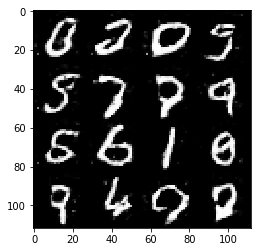

Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 2.1689
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 1.5765
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 1.2883


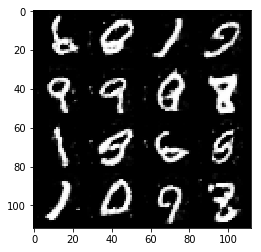

Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 0.3278... Generator Loss: 1.9322
Epoch 2/2... Discriminator Loss: 0.3327... Generator Loss: 1.5624
Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 1.8421


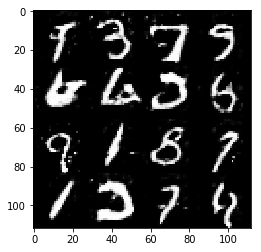

Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 0.3176... Generator Loss: 1.9319
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 1.3229
Epoch 2/2... Discriminator Loss: 0.4132... Generator Loss: 1.9135


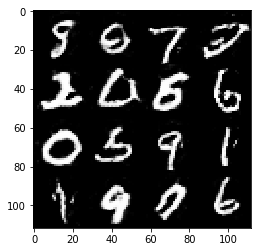

Epoch 2/2... Discriminator Loss: 0.2744... Generator Loss: 2.2152
Epoch 2/2... Discriminator Loss: 0.3408... Generator Loss: 1.8911
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 1.9523


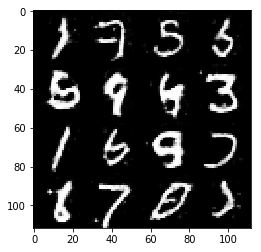

Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 0.2067... Generator Loss: 2.1074
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 3.0849


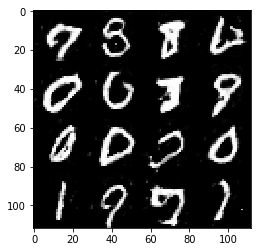

Epoch 2/2... Discriminator Loss: 0.2268... Generator Loss: 2.0125
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 1.8245
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.3714


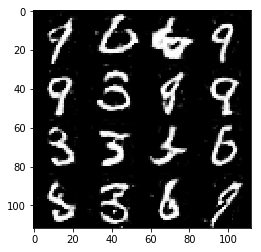

Epoch 2/2... Discriminator Loss: 0.1996... Generator Loss: 2.1999
Epoch 2/2... Discriminator Loss: 0.1586... Generator Loss: 2.4139


In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.1707


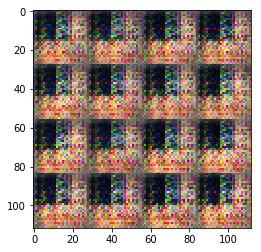

Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.0093


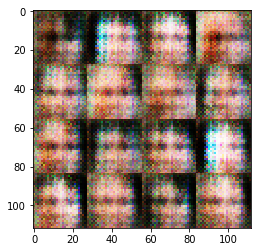

Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.8914


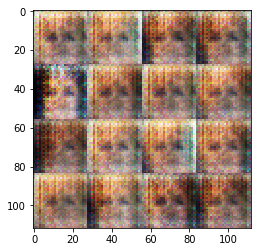

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6695


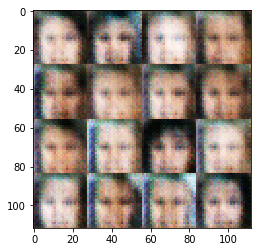

Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.8962


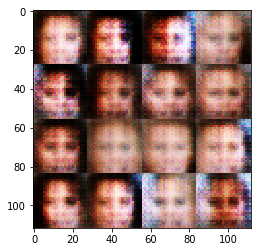

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.7617


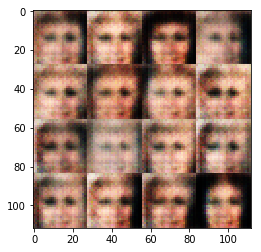

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6608


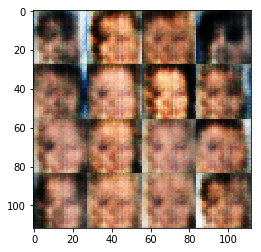

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.6522


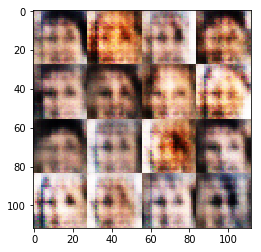

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8358


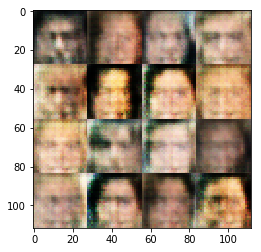

Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7305


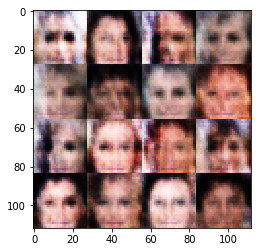

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.5716


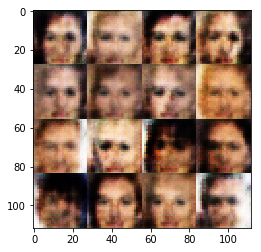

Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7971


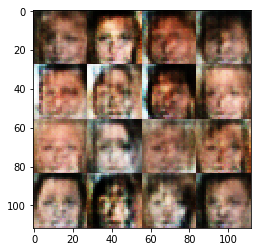

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7819


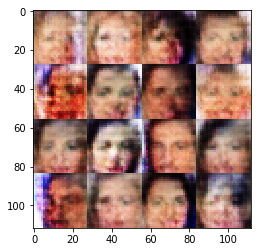

Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7259


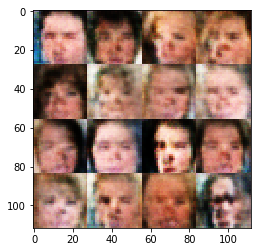

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7565


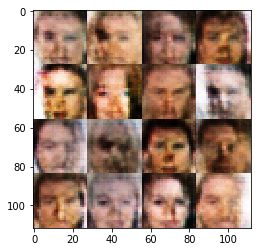

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7004


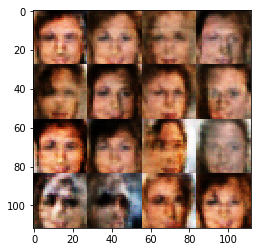

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7154


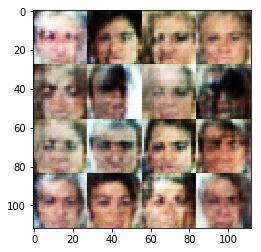

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6391


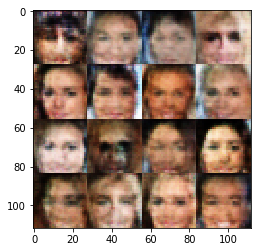

Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7489


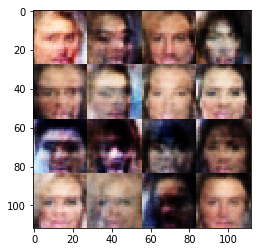

Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.7844


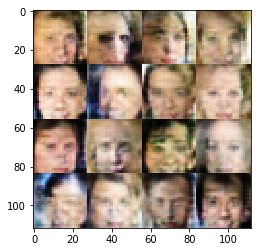

Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7631


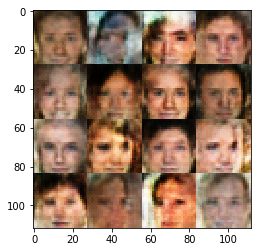

Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7830


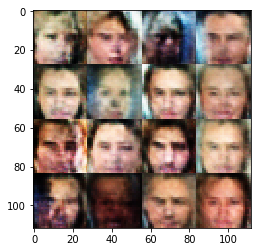

Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.6759


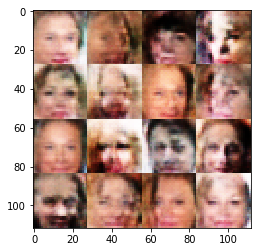

Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7582


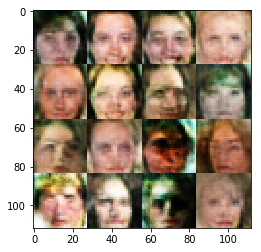

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.8215


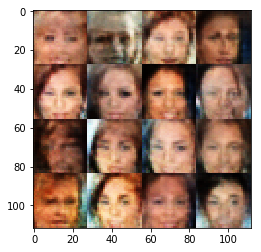

Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6369


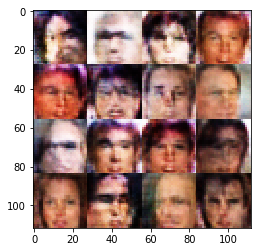

Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7119


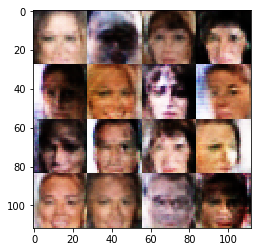

Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7304


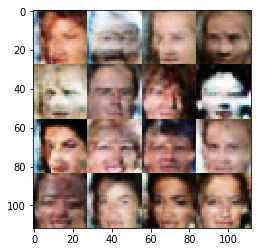

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7382


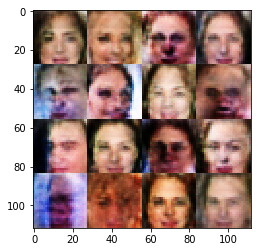

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7222


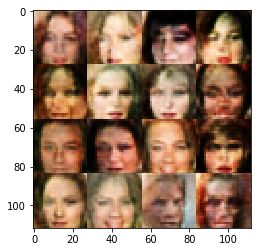

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7177


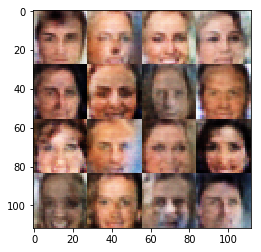

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7092


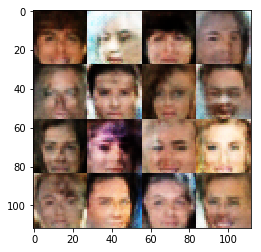

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6595


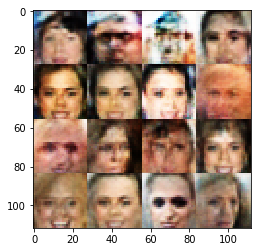

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.7675


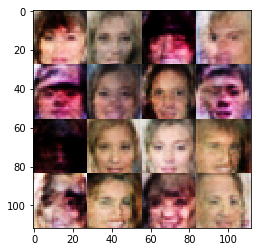

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7360


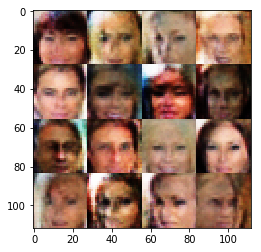

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7511


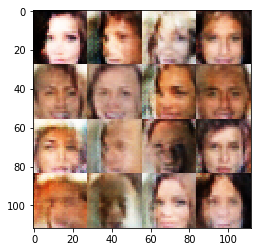

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7234


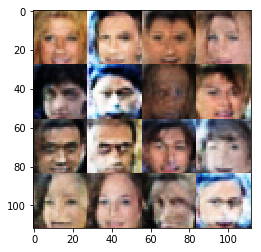

Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6871


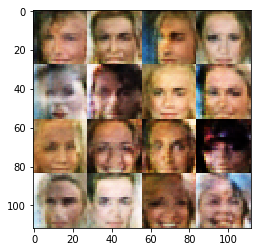

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7494


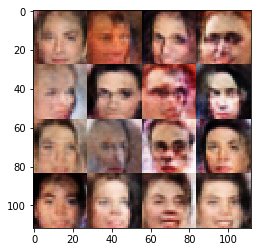

Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7882


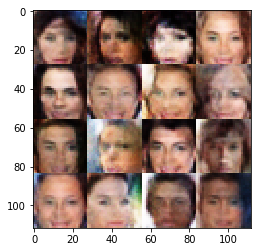

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6036


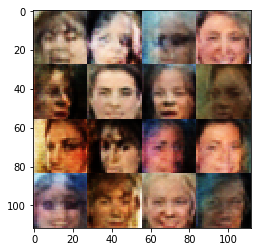

Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6401


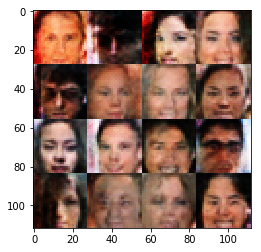

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6082


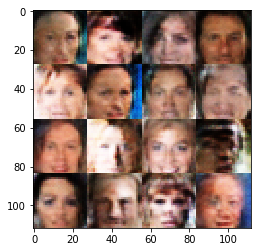

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7177


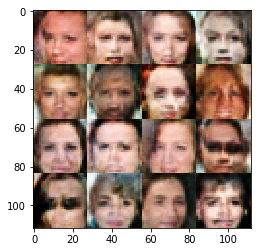

Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7078


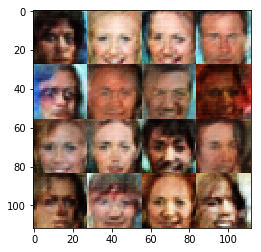

Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.6884


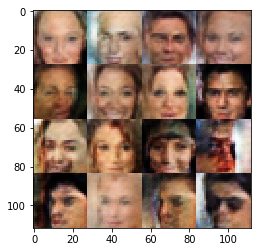

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8600


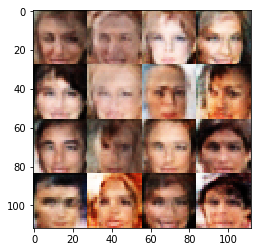

Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8129


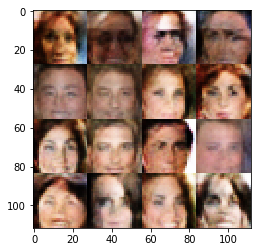

Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6269


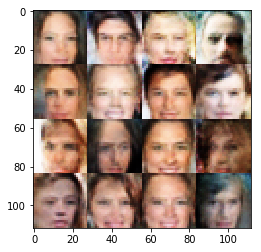

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7548


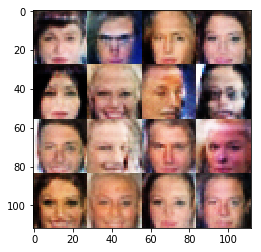

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.8025


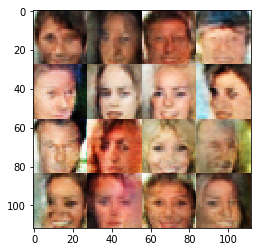

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7412


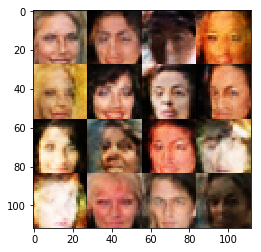

Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7063


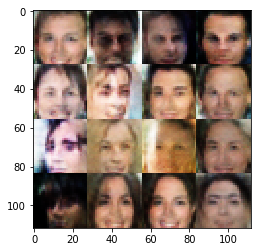

Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7907


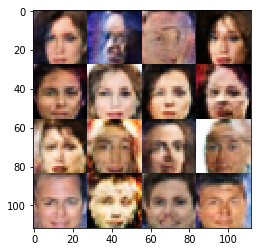

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7095


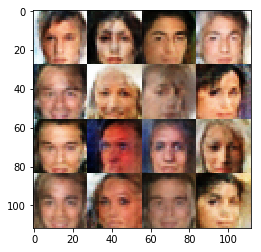

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7085


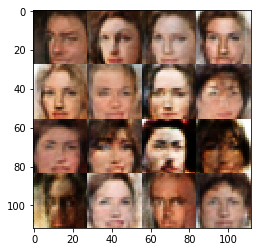

Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7170


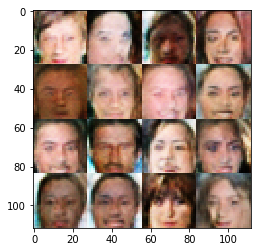

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7187


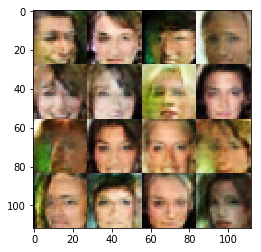

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7376


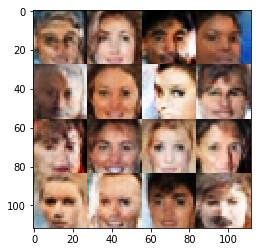

Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7428


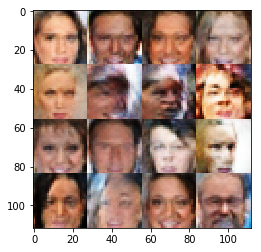

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6977


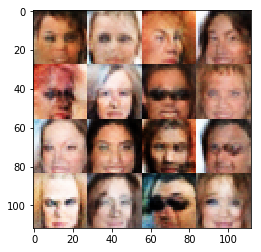

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7411


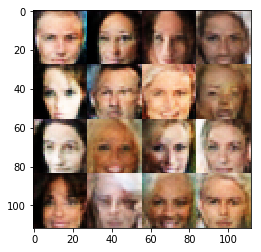

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6478


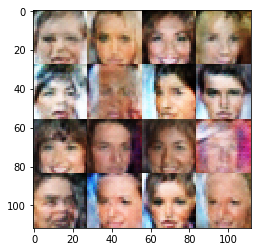

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7083


In [14]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.